# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_sm_loss
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 30, 
    'valid_batch_size': 78,
    'test_batch_size': 99,
    'sim_threshold': 1,
    'learning_rate': 5e-4,
    'step_size': 15,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 100,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_TRANSFER',
    'model_pretrained_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_UPSCALING'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'], insitu_validation=True)

***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015104\4.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015104\4.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\17.npy
D:\1GRAD

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015211\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015211\27.npy
_____________________________smap cell: 44_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015211\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015211\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015211\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015211\11.npy
_____________________________smap cell: 45_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015211\45.npy
D:\1GRADUATED\paper\downscaling_data\

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015290\31.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015290\10.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015290\10.npy
_____________________________smap cell: 32_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015290\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015290\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015290\54.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015290\54.npy
_____________________________smap cell: 33_____________________________
D:\1GRADUATED\paper\downscaling_data\

In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_insitu_validation)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_insitu_validation)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 316
validing size 78
testing size 99


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_sm_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
#         if epoch==10:
#             config['sim_threshold'] = 0.93
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
            relu(pred[:, 0])
#             print(pred)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Training', config['sim_threshold'])
            loss = physical_loss + sim_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.detach().item())
            sim_loss_record.append(sim_loss.detach().item())
            loss_record.append(loss.detach().item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
                relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
                loss = physical_loss + sim_loss
            
            physical_loss_record.append(physical_loss.item())
            sim_loss_record.append(sim_loss.item())
            loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f} || Train similarity loss: {mean_train_sim_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f} || Valid similarity loss: {mean_valid_sim_loss:.4f}')
            
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


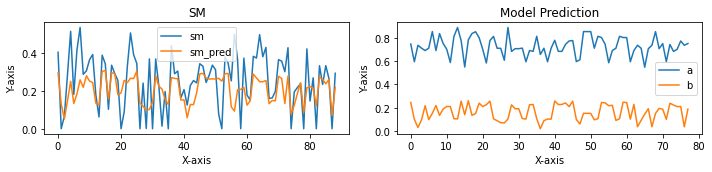

Epoch [1/5000] (LR: 0.0005):
Train loss: 0.0241 || Train physical loss: 0.0241 || Train similarity loss: 0.0000
Valid loss: 0.0171 || Valid physical loss: 0.0171 || Valid similarity loss: 0.0000
Saving model with loss 0.017...


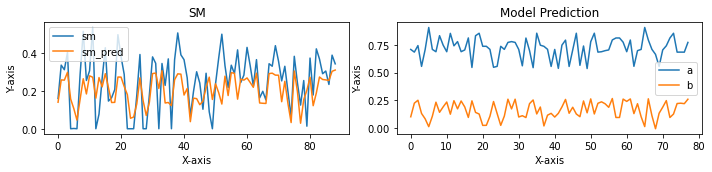

Epoch [2/5000] (LR: 0.0005):
Train loss: 0.0245 || Train physical loss: 0.0245 || Train similarity loss: 0.0000
Valid loss: 0.0154 || Valid physical loss: 0.0154 || Valid similarity loss: 0.0000
Saving model with loss 0.015...


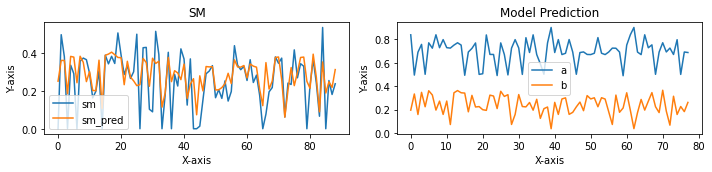

Epoch [3/5000] (LR: 0.0005):
Train loss: 0.0209 || Train physical loss: 0.0209 || Train similarity loss: 0.0000
Valid loss: 0.0139 || Valid physical loss: 0.0139 || Valid similarity loss: 0.0000
Saving model with loss 0.014...


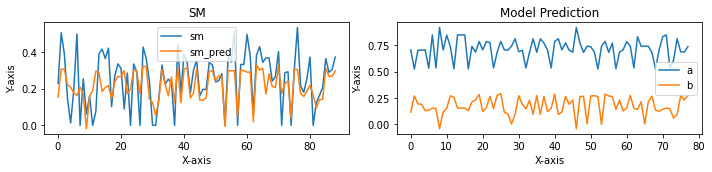

Epoch [4/5000] (LR: 0.0005):
Train loss: 0.0208 || Train physical loss: 0.0208 || Train similarity loss: 0.0000
Valid loss: 0.0130 || Valid physical loss: 0.0130 || Valid similarity loss: 0.0000
Saving model with loss 0.013...


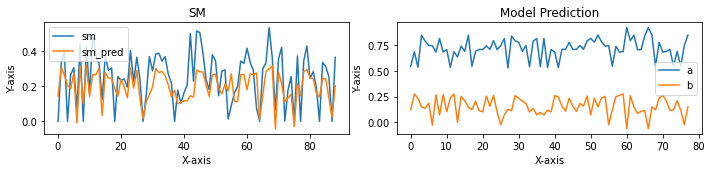

Epoch [5/5000] (LR: 0.0005):
Train loss: 0.0187 || Train physical loss: 0.0187 || Train similarity loss: 0.0000
Valid loss: 0.0143 || Valid physical loss: 0.0143 || Valid similarity loss: 0.0000


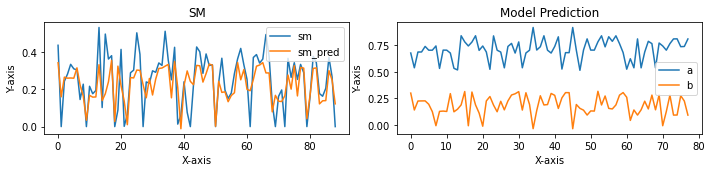

Epoch [6/5000] (LR: 0.0005):
Train loss: 0.0191 || Train physical loss: 0.0191 || Train similarity loss: 0.0000
Valid loss: 0.0120 || Valid physical loss: 0.0120 || Valid similarity loss: 0.0000
Saving model with loss 0.012...


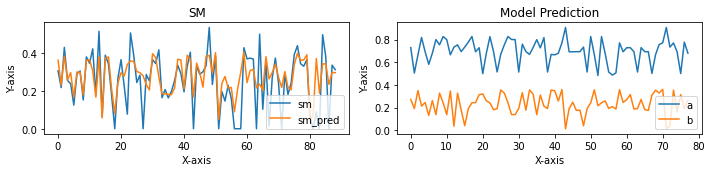

Epoch [7/5000] (LR: 0.0005):
Train loss: 0.0191 || Train physical loss: 0.0191 || Train similarity loss: 0.0000
Valid loss: 0.0120 || Valid physical loss: 0.0120 || Valid similarity loss: 0.0000


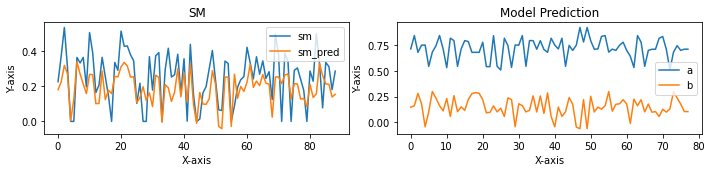

Epoch [8/5000] (LR: 0.0005):
Train loss: 0.0182 || Train physical loss: 0.0182 || Train similarity loss: 0.0000
Valid loss: 0.0143 || Valid physical loss: 0.0143 || Valid similarity loss: 0.0000


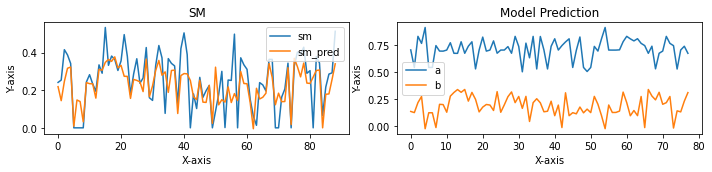

Epoch [9/5000] (LR: 0.0005):
Train loss: 0.0177 || Train physical loss: 0.0177 || Train similarity loss: 0.0000
Valid loss: 0.0119 || Valid physical loss: 0.0119 || Valid similarity loss: 0.0000
Saving model with loss 0.012...


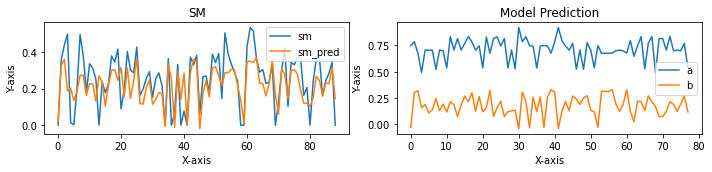

Epoch [10/5000] (LR: 0.0005):
Train loss: 0.0174 || Train physical loss: 0.0174 || Train similarity loss: 0.0000
Valid loss: 0.0119 || Valid physical loss: 0.0119 || Valid similarity loss: 0.0000


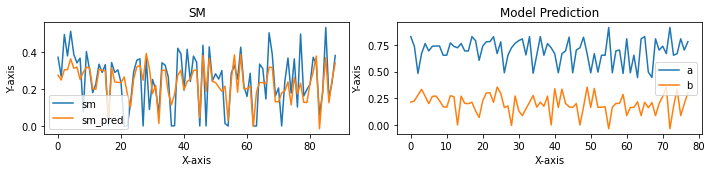

Epoch [11/5000] (LR: 0.0005):
Train loss: 0.0176 || Train physical loss: 0.0176 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000
Saving model with loss 0.011...


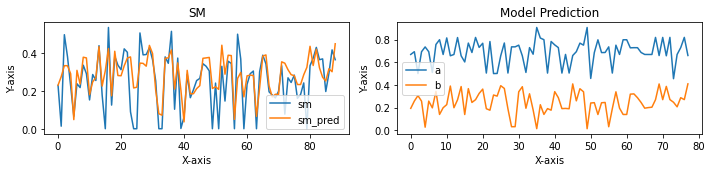

Epoch [12/5000] (LR: 0.0005):
Train loss: 0.0169 || Train physical loss: 0.0169 || Train similarity loss: 0.0000
Valid loss: 0.0124 || Valid physical loss: 0.0124 || Valid similarity loss: 0.0000


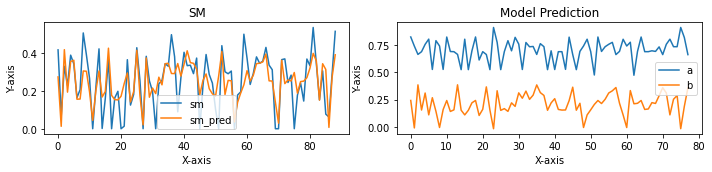

Epoch [13/5000] (LR: 0.0005):
Train loss: 0.0182 || Train physical loss: 0.0182 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


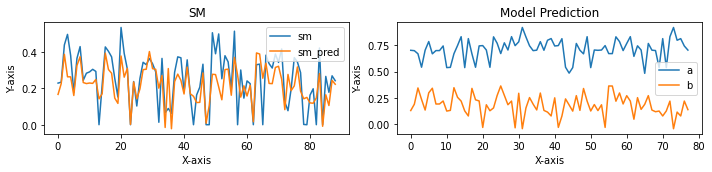

Epoch [14/5000] (LR: 0.0005):
Train loss: 0.0172 || Train physical loss: 0.0172 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


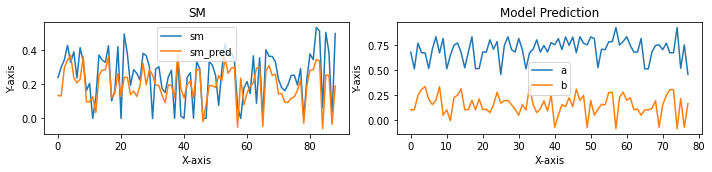

Epoch [15/5000] (LR: 0.0005):
Train loss: 0.0182 || Train physical loss: 0.0182 || Train similarity loss: 0.0000
Valid loss: 0.0133 || Valid physical loss: 0.0133 || Valid similarity loss: 0.0000


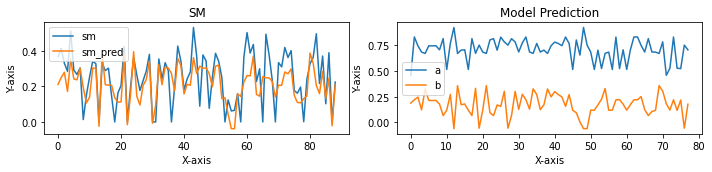

Epoch [16/5000] (LR: 0.0005):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0122 || Valid physical loss: 0.0122 || Valid similarity loss: 0.0000


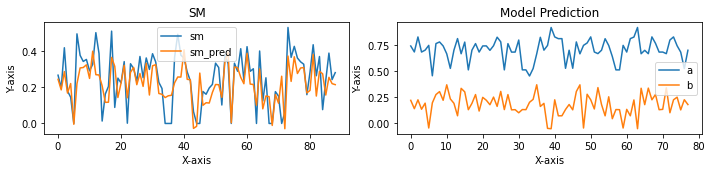

Epoch [17/5000] (LR: 0.0005):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0116 || Valid physical loss: 0.0116 || Valid similarity loss: 0.0000


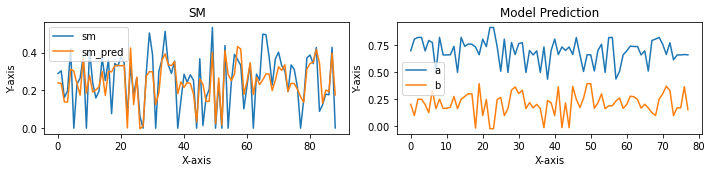

Epoch [18/5000] (LR: 0.0005):
Train loss: 0.0166 || Train physical loss: 0.0166 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000


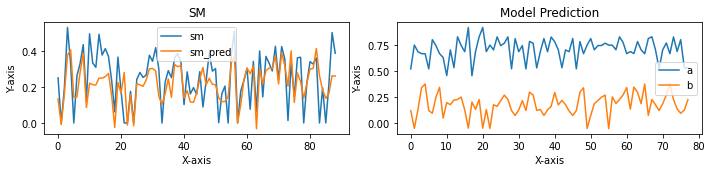

Epoch [19/5000] (LR: 0.0005):
Train loss: 0.0164 || Train physical loss: 0.0164 || Train similarity loss: 0.0000
Valid loss: 0.0117 || Valid physical loss: 0.0117 || Valid similarity loss: 0.0000


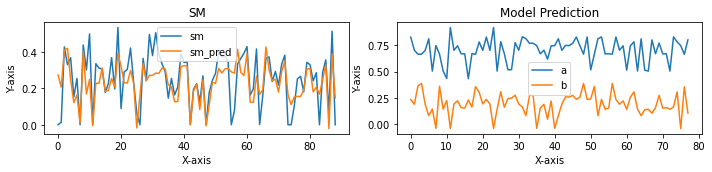

Epoch [20/5000] (LR: 0.0005):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000


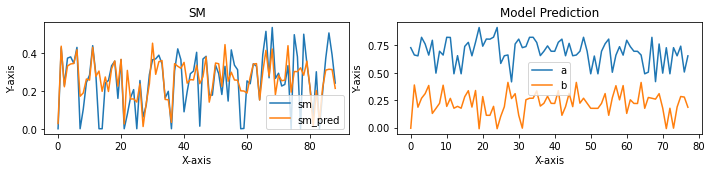

Epoch [21/5000] (LR: 0.0005):
Train loss: 0.0168 || Train physical loss: 0.0168 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


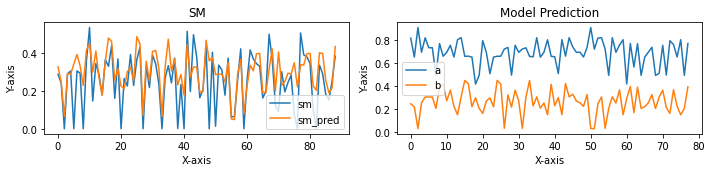

Epoch [22/5000] (LR: 0.0005):
Train loss: 0.0189 || Train physical loss: 0.0189 || Train similarity loss: 0.0000
Valid loss: 0.0140 || Valid physical loss: 0.0140 || Valid similarity loss: 0.0000


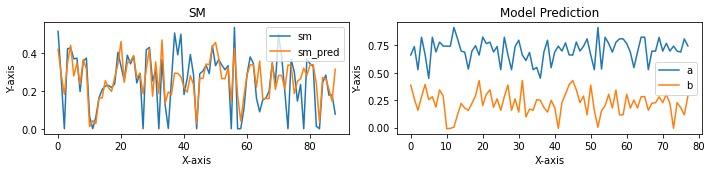

Epoch [23/5000] (LR: 0.0005):
Train loss: 0.0182 || Train physical loss: 0.0182 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


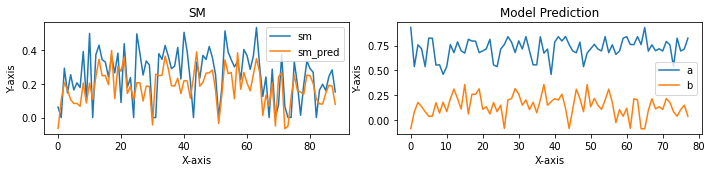

Epoch [24/5000] (LR: 0.0005):
Train loss: 0.0171 || Train physical loss: 0.0171 || Train similarity loss: 0.0000
Valid loss: 0.0147 || Valid physical loss: 0.0147 || Valid similarity loss: 0.0000


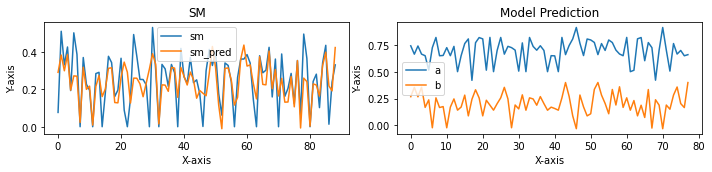

Epoch [25/5000] (LR: 0.0005):
Train loss: 0.0164 || Train physical loss: 0.0164 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


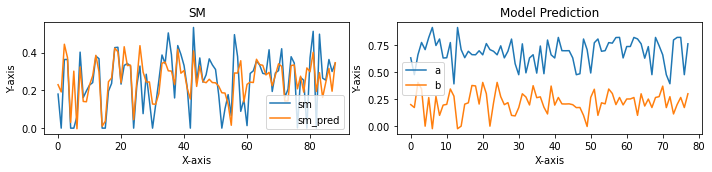

Epoch [26/5000] (LR: 0.0005):
Train loss: 0.0162 || Train physical loss: 0.0162 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


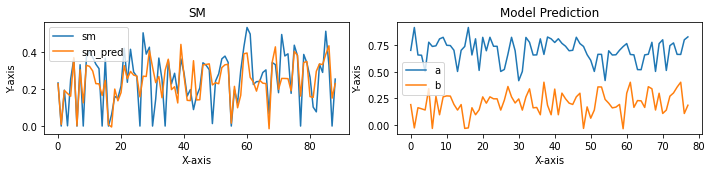

Epoch [27/5000] (LR: 0.0005):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


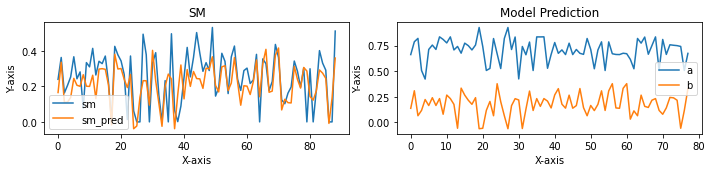

Epoch [28/5000] (LR: 0.00025):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0121 || Valid physical loss: 0.0121 || Valid similarity loss: 0.0000


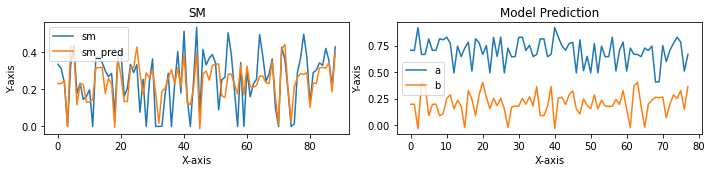

Epoch [29/5000] (LR: 0.00025):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000


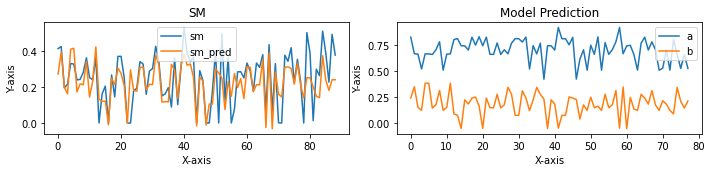

Epoch [30/5000] (LR: 0.00025):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0115 || Valid physical loss: 0.0115 || Valid similarity loss: 0.0000


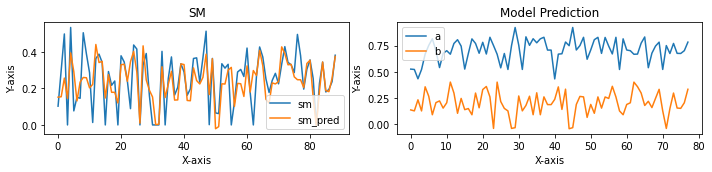

Epoch [31/5000] (LR: 0.00025):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


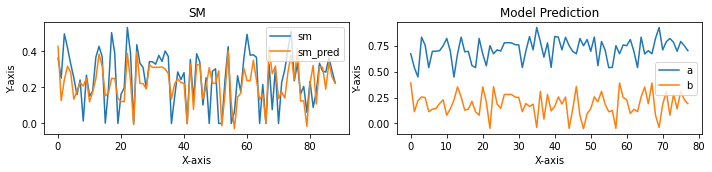

Epoch [32/5000] (LR: 0.00025):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0115 || Valid physical loss: 0.0115 || Valid similarity loss: 0.0000


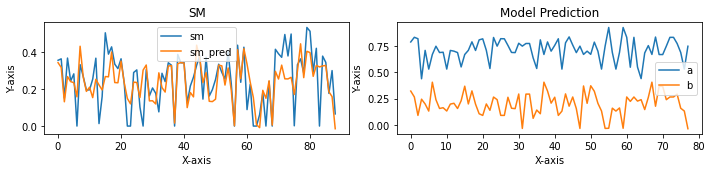

Epoch [33/5000] (LR: 0.00025):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


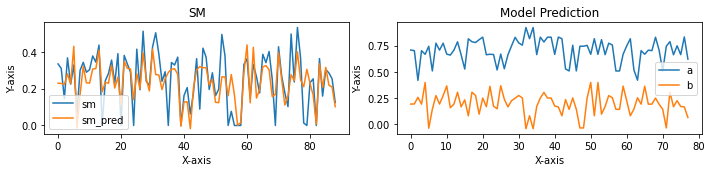

Epoch [34/5000] (LR: 0.00025):
Train loss: 0.0164 || Train physical loss: 0.0164 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000
Saving model with loss 0.011...


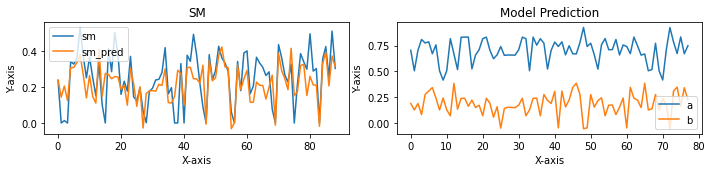

Epoch [35/5000] (LR: 0.00025):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


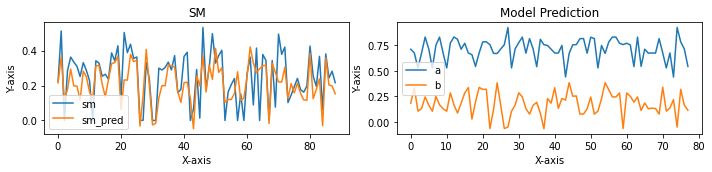

Epoch [36/5000] (LR: 0.00025):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0124 || Valid physical loss: 0.0124 || Valid similarity loss: 0.0000


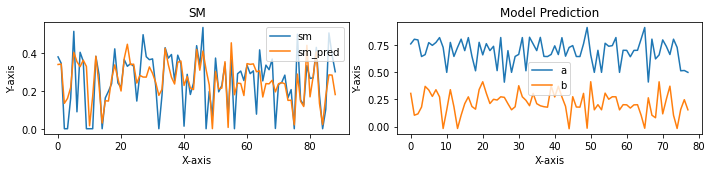

Epoch [37/5000] (LR: 0.00025):
Train loss: 0.0163 || Train physical loss: 0.0163 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


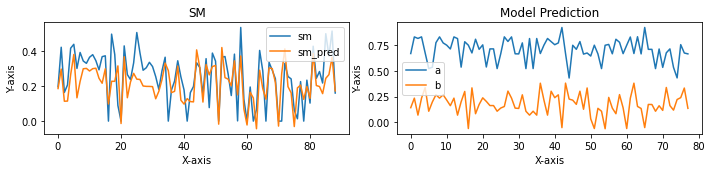

Epoch [38/5000] (LR: 0.00025):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0122 || Valid physical loss: 0.0122 || Valid similarity loss: 0.0000


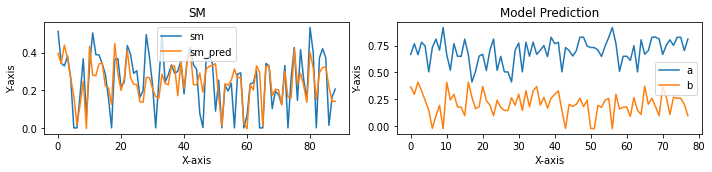

Epoch [39/5000] (LR: 0.00025):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000


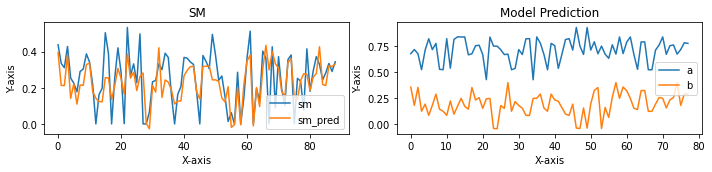

Epoch [40/5000] (LR: 0.00025):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


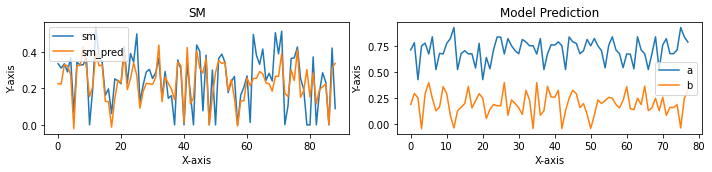

Epoch [41/5000] (LR: 0.00025):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


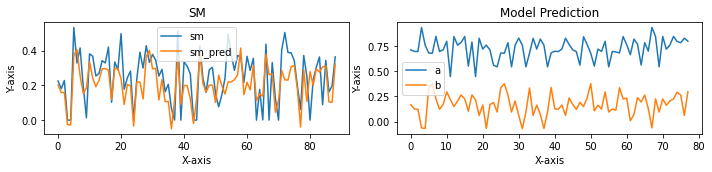

Epoch [42/5000] (LR: 0.00025):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0125 || Valid physical loss: 0.0125 || Valid similarity loss: 0.0000


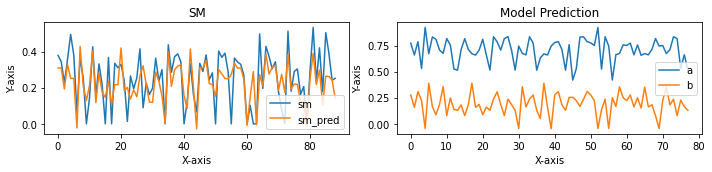

Epoch [43/5000] (LR: 0.00025):
Train loss: 0.0168 || Train physical loss: 0.0168 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


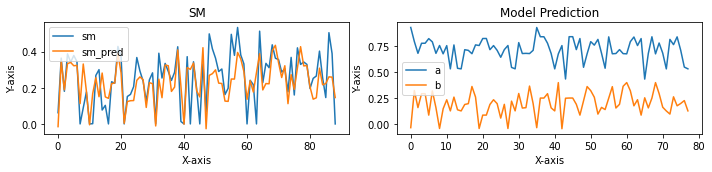

Epoch [44/5000] (LR: 0.000125):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


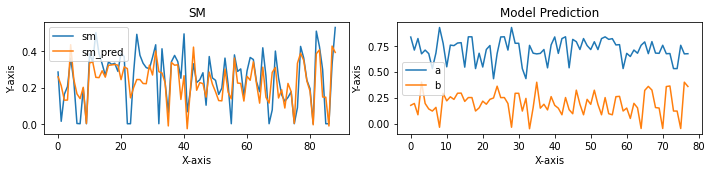

Epoch [45/5000] (LR: 0.000125):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


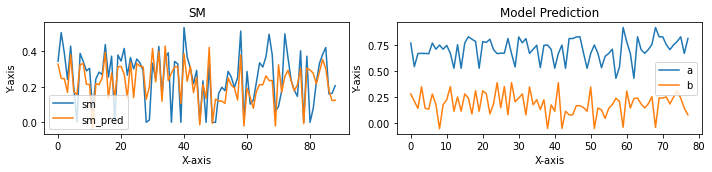

Epoch [46/5000] (LR: 0.000125):
Train loss: 0.0163 || Train physical loss: 0.0163 || Train similarity loss: 0.0000
Valid loss: 0.0115 || Valid physical loss: 0.0115 || Valid similarity loss: 0.0000


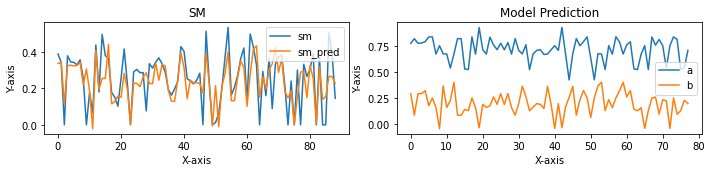

Epoch [47/5000] (LR: 0.000125):
Train loss: 0.0165 || Train physical loss: 0.0165 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


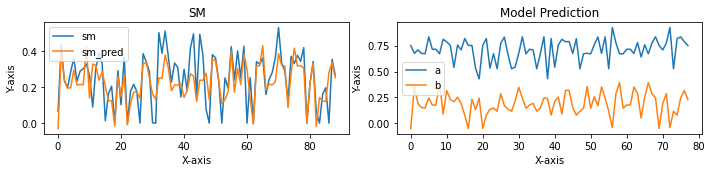

Epoch [48/5000] (LR: 0.000125):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


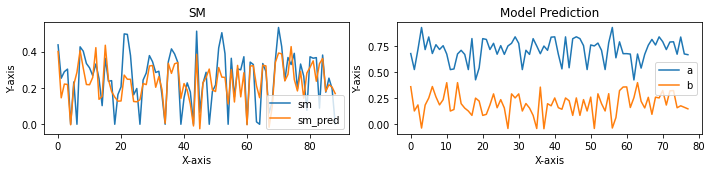

Epoch [49/5000] (LR: 0.000125):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


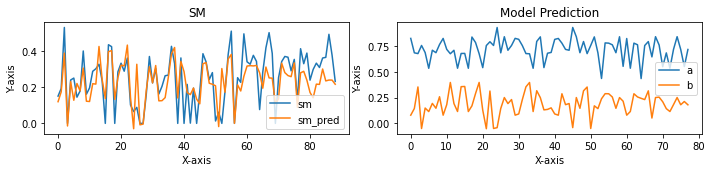

Epoch [50/5000] (LR: 0.000125):
Train loss: 0.0150 || Train physical loss: 0.0150 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


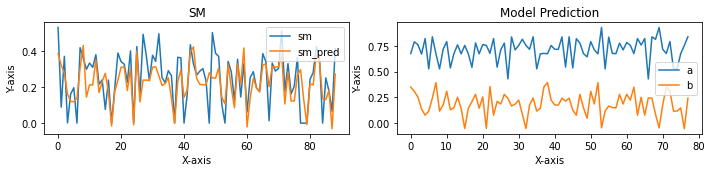

Epoch [51/5000] (LR: 0.000125):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


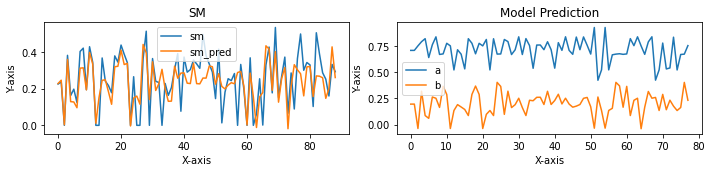

Epoch [52/5000] (LR: 0.000125):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0109 || Valid physical loss: 0.0109 || Valid similarity loss: 0.0000


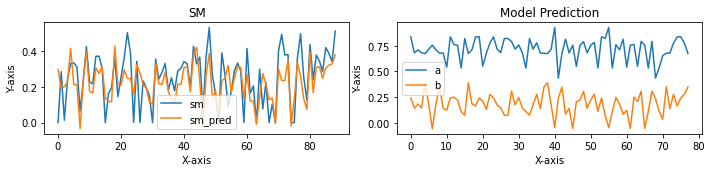

Epoch [53/5000] (LR: 0.000125):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0115 || Valid physical loss: 0.0115 || Valid similarity loss: 0.0000


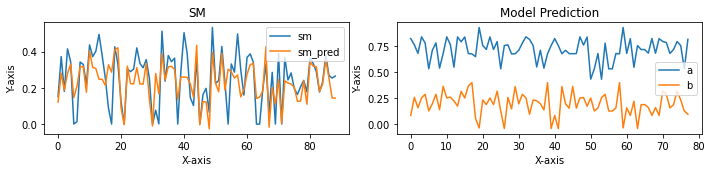

Epoch [54/5000] (LR: 0.000125):
Train loss: 0.0164 || Train physical loss: 0.0164 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


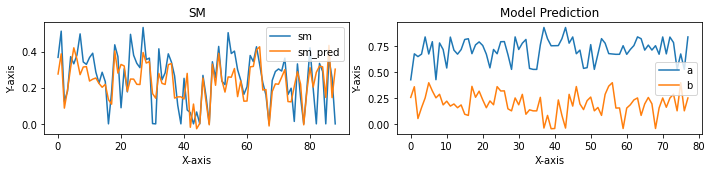

Epoch [55/5000] (LR: 0.000125):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


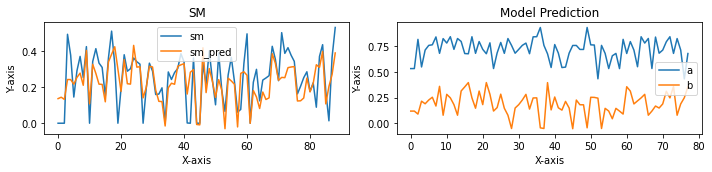

Epoch [56/5000] (LR: 0.000125):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


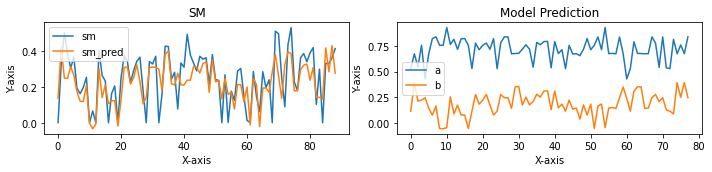

Epoch [57/5000] (LR: 0.000125):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


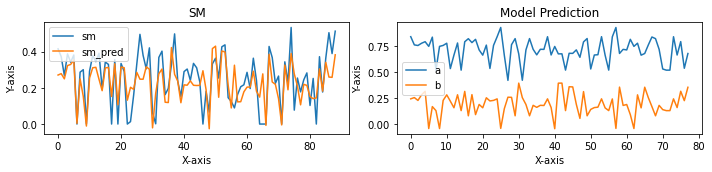

Epoch [58/5000] (LR: 0.000125):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


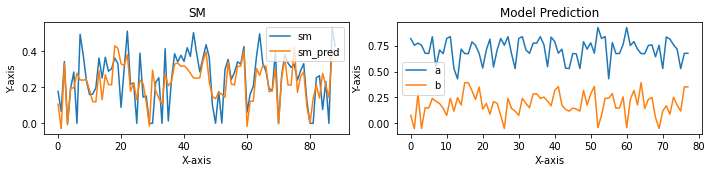

Epoch [59/5000] (LR: 0.000125):
Train loss: 0.0160 || Train physical loss: 0.0160 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


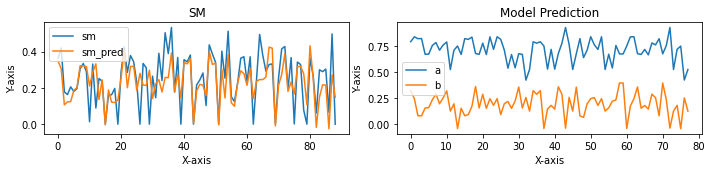

Epoch [60/5000] (LR: 6.25e-05):
Train loss: 0.0165 || Train physical loss: 0.0165 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


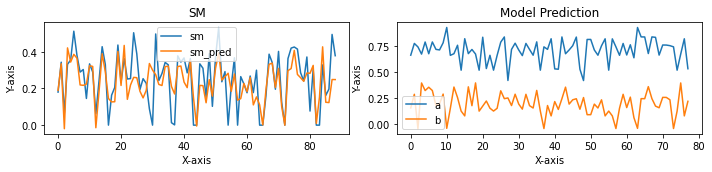

Epoch [61/5000] (LR: 6.25e-05):
Train loss: 0.0169 || Train physical loss: 0.0169 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


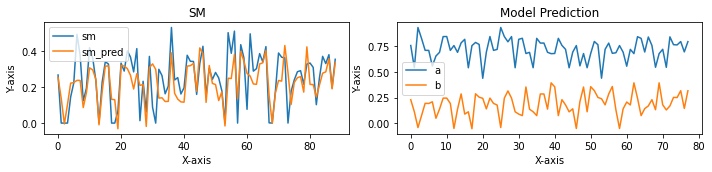

Epoch [62/5000] (LR: 6.25e-05):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


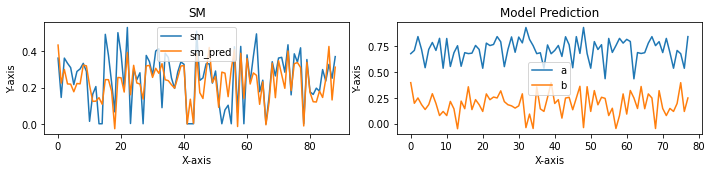

Epoch [63/5000] (LR: 6.25e-05):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


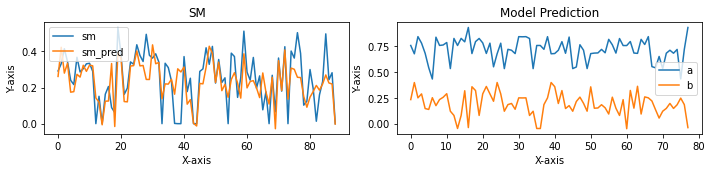

Epoch [64/5000] (LR: 6.25e-05):
Train loss: 0.0162 || Train physical loss: 0.0162 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


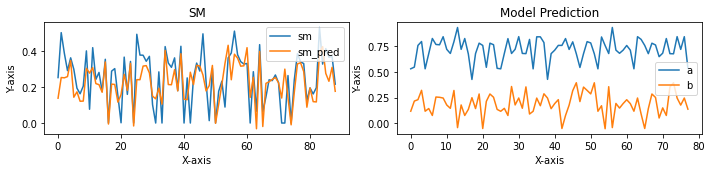

Epoch [65/5000] (LR: 6.25e-05):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


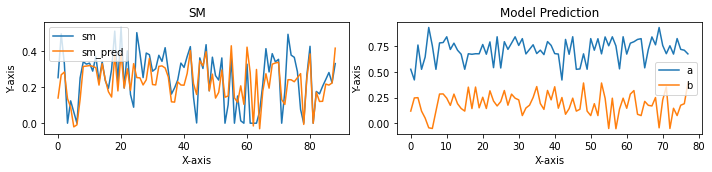

Epoch [66/5000] (LR: 6.25e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


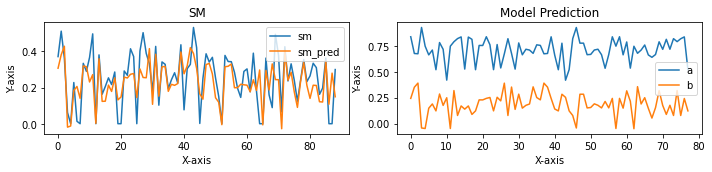

Epoch [67/5000] (LR: 6.25e-05):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


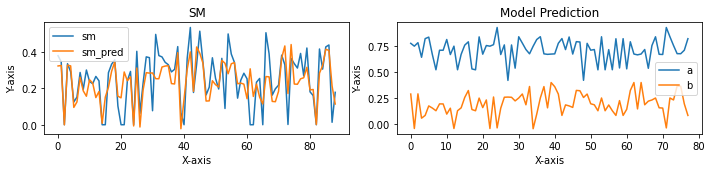

Epoch [68/5000] (LR: 6.25e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


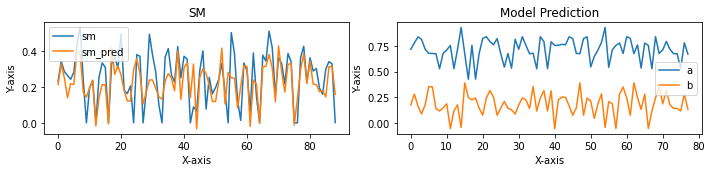

Epoch [69/5000] (LR: 6.25e-05):
Train loss: 0.0162 || Train physical loss: 0.0162 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


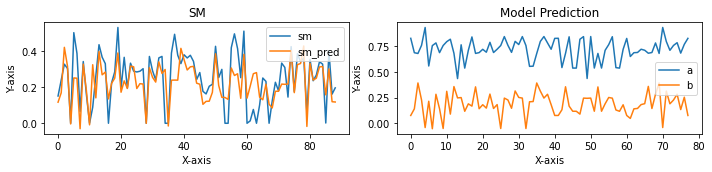

Epoch [70/5000] (LR: 6.25e-05):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


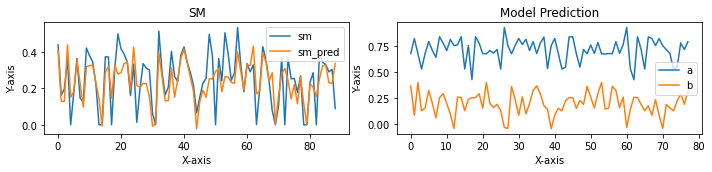

Epoch [71/5000] (LR: 6.25e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


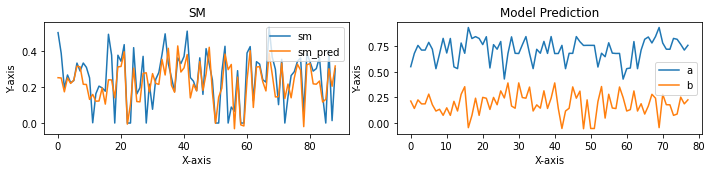

Epoch [72/5000] (LR: 6.25e-05):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


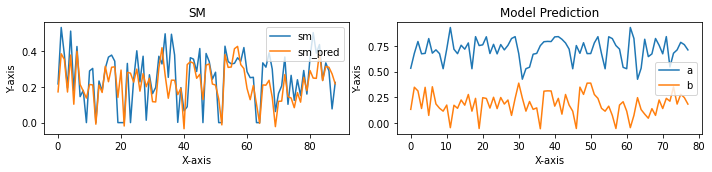

Epoch [73/5000] (LR: 6.25e-05):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


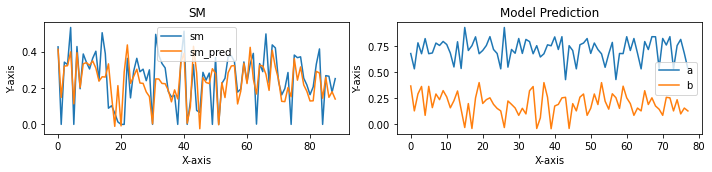

Epoch [74/5000] (LR: 6.25e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0110 || Valid physical loss: 0.0110 || Valid similarity loss: 0.0000


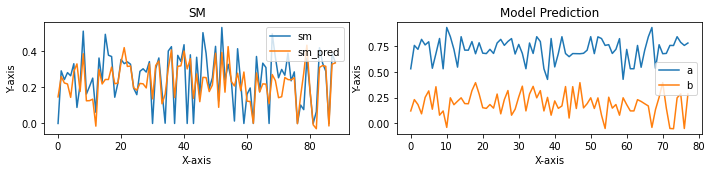

Epoch [75/5000] (LR: 6.25e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


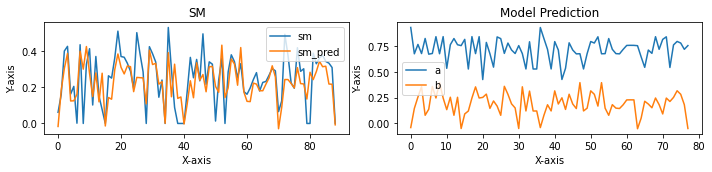

Epoch [76/5000] (LR: 3.125e-05):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


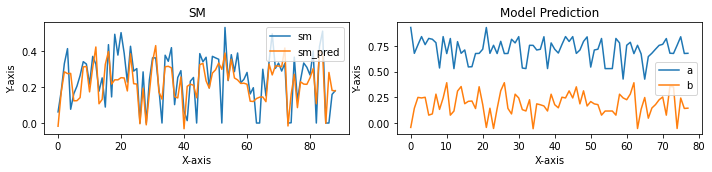

Epoch [77/5000] (LR: 3.125e-05):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


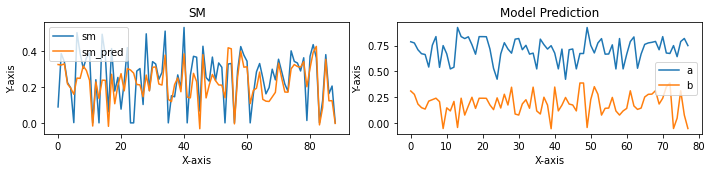

Epoch [78/5000] (LR: 3.125e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000


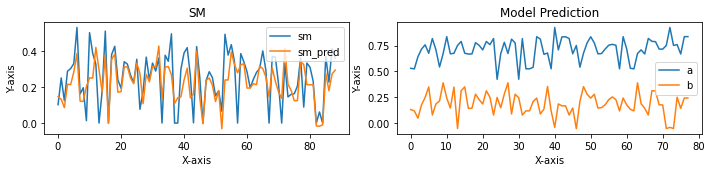

Epoch [79/5000] (LR: 3.125e-05):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


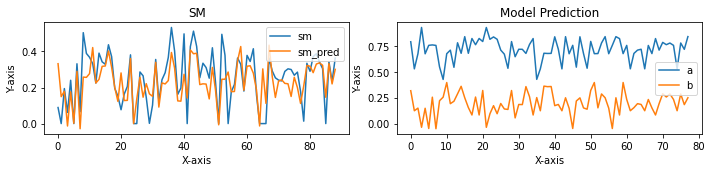

Epoch [80/5000] (LR: 3.125e-05):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


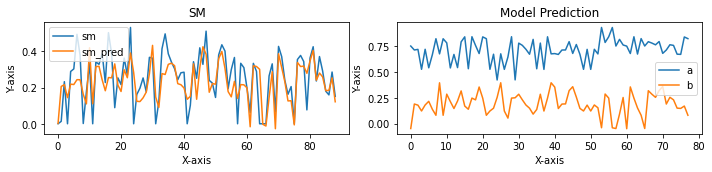

Epoch [81/5000] (LR: 3.125e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


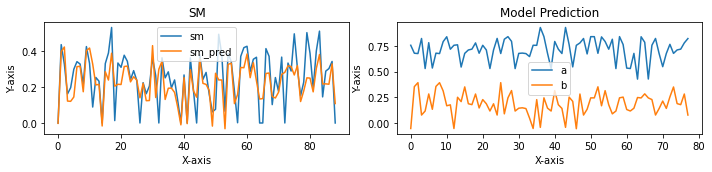

Epoch [82/5000] (LR: 3.125e-05):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


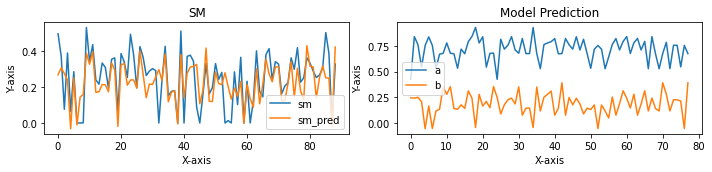

Epoch [83/5000] (LR: 3.125e-05):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


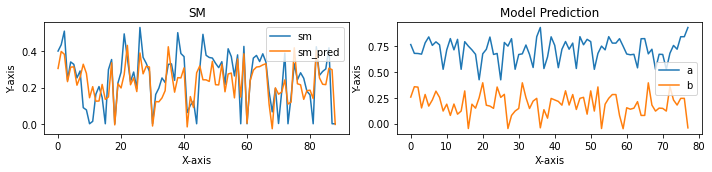

Epoch [84/5000] (LR: 3.125e-05):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


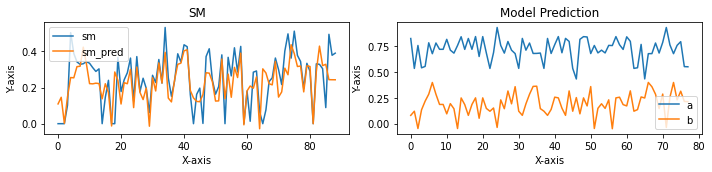

Epoch [85/5000] (LR: 3.125e-05):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


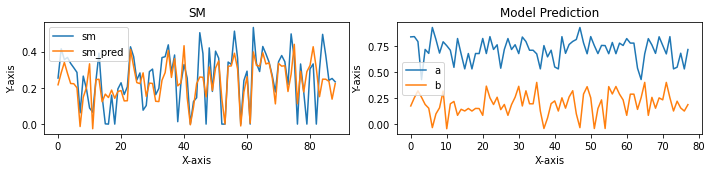

Epoch [86/5000] (LR: 3.125e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


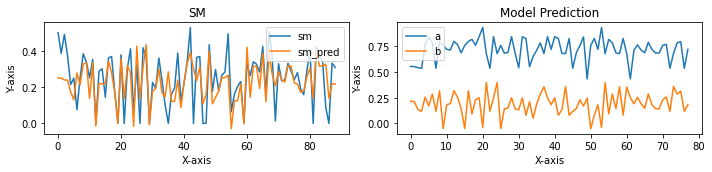

Epoch [87/5000] (LR: 3.125e-05):
Train loss: 0.0167 || Train physical loss: 0.0167 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


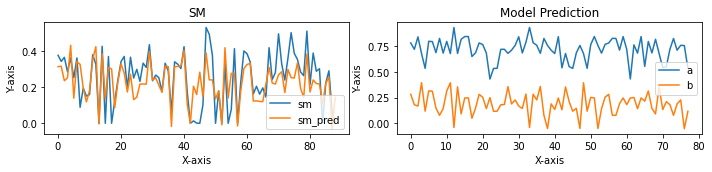

Epoch [88/5000] (LR: 3.125e-05):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


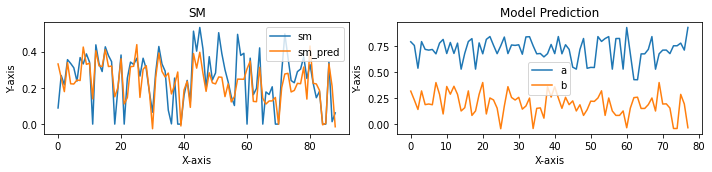

Epoch [89/5000] (LR: 3.125e-05):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


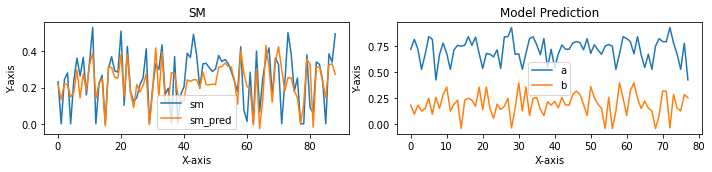

Epoch [90/5000] (LR: 3.125e-05):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


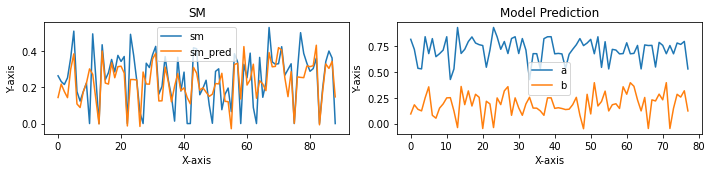

Epoch [91/5000] (LR: 3.125e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


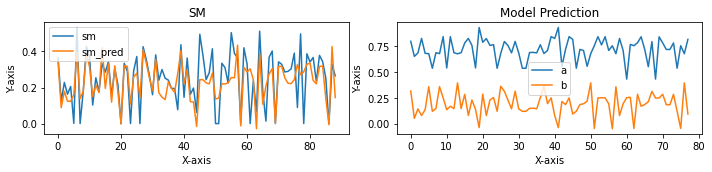

Epoch [92/5000] (LR: 1.5625e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


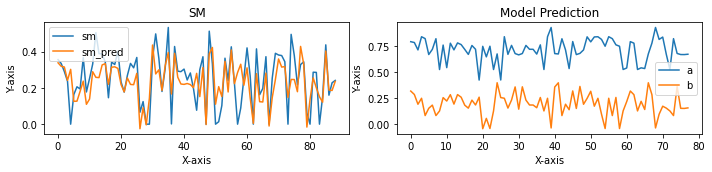

Epoch [93/5000] (LR: 1.5625e-05):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


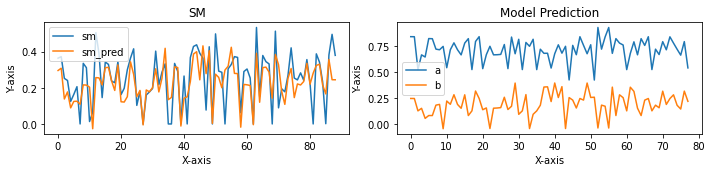

Epoch [94/5000] (LR: 1.5625e-05):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


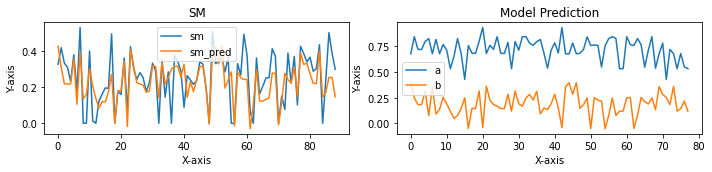

Epoch [95/5000] (LR: 1.5625e-05):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


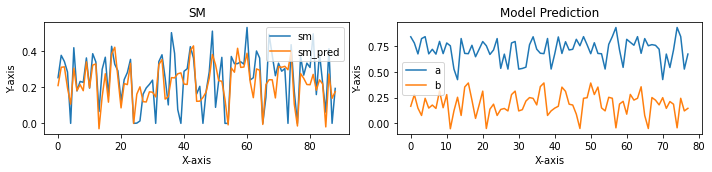

Epoch [96/5000] (LR: 1.5625e-05):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


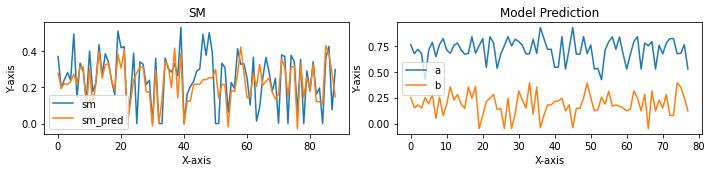

Epoch [97/5000] (LR: 1.5625e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


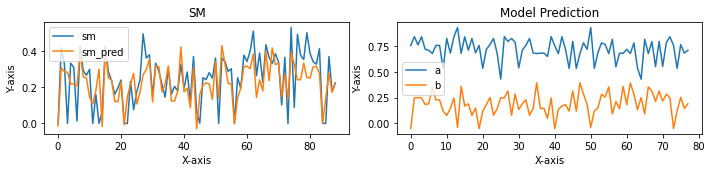

Epoch [98/5000] (LR: 1.5625e-05):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


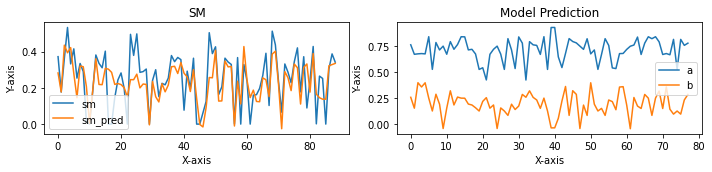

Epoch [99/5000] (LR: 1.5625e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


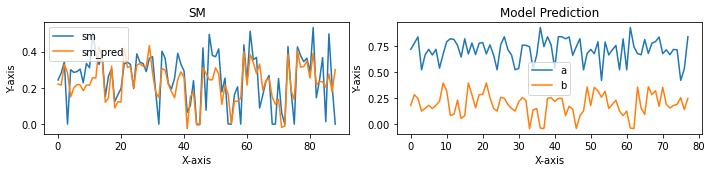

Epoch [100/5000] (LR: 1.5625e-05):
Train loss: 0.0151 || Train physical loss: 0.0151 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


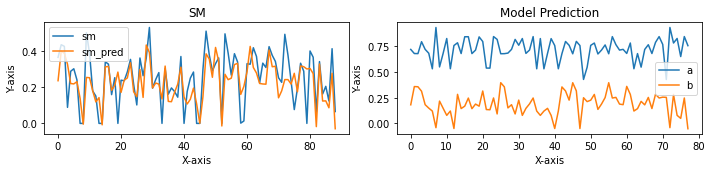

Epoch [101/5000] (LR: 1.5625e-05):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


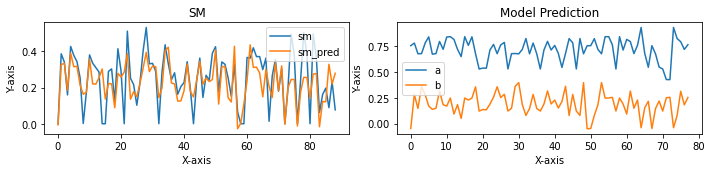

Epoch [102/5000] (LR: 1.5625e-05):
Train loss: 0.0161 || Train physical loss: 0.0161 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


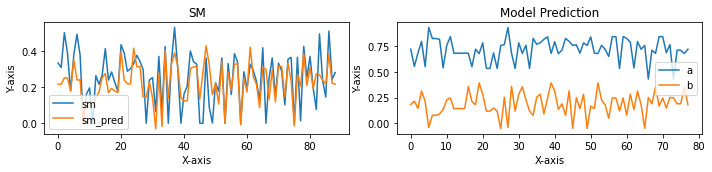

Epoch [103/5000] (LR: 1.5625e-05):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


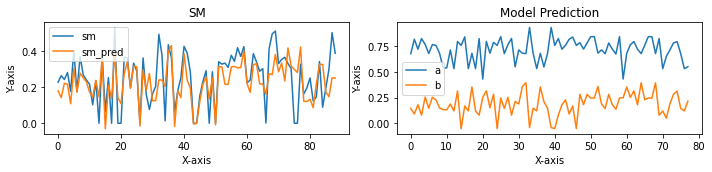

Epoch [104/5000] (LR: 1.5625e-05):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0113 || Valid physical loss: 0.0113 || Valid similarity loss: 0.0000


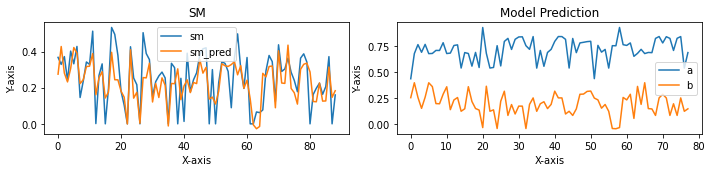

Epoch [105/5000] (LR: 1.5625e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


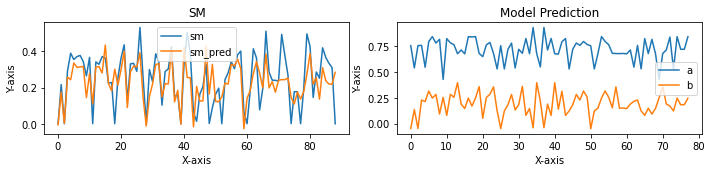

Epoch [106/5000] (LR: 1.5625e-05):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


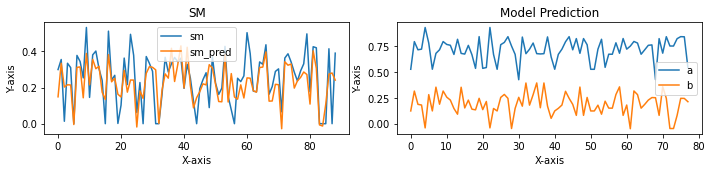

Epoch [107/5000] (LR: 1.5625e-05):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


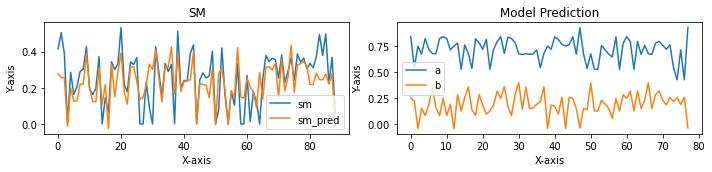

Epoch [108/5000] (LR: 7.8125e-06):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


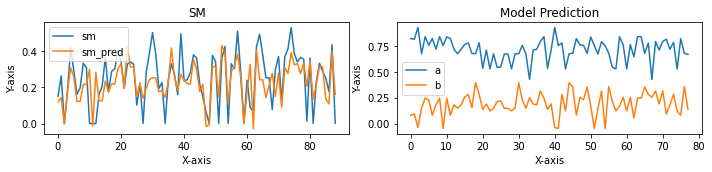

Epoch [109/5000] (LR: 7.8125e-06):
Train loss: 0.0151 || Train physical loss: 0.0151 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


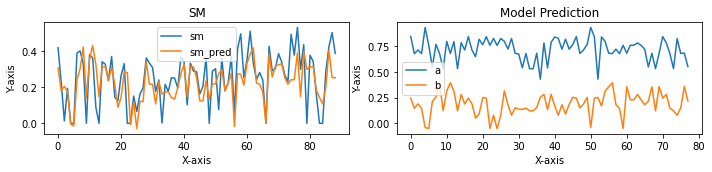

Epoch [110/5000] (LR: 7.8125e-06):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


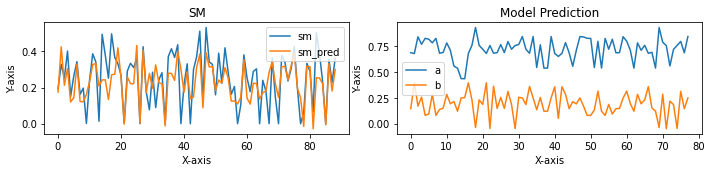

Epoch [111/5000] (LR: 7.8125e-06):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


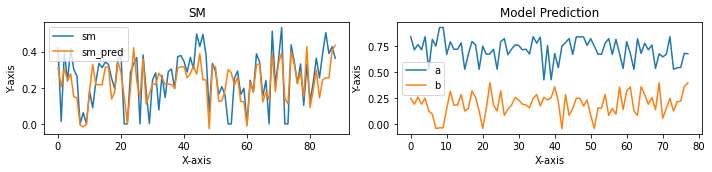

Epoch [112/5000] (LR: 7.8125e-06):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


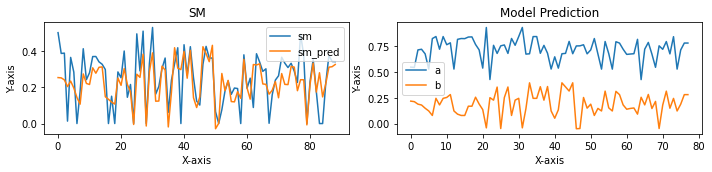

Epoch [113/5000] (LR: 7.8125e-06):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


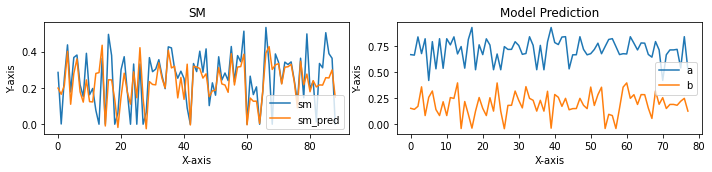

Epoch [114/5000] (LR: 7.8125e-06):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


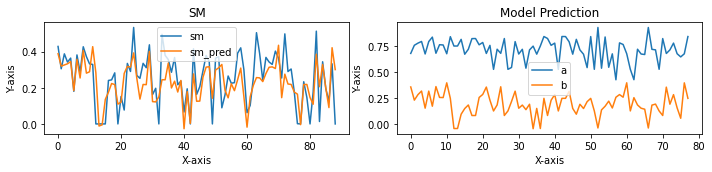

Epoch [115/5000] (LR: 7.8125e-06):
Train loss: 0.0152 || Train physical loss: 0.0152 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


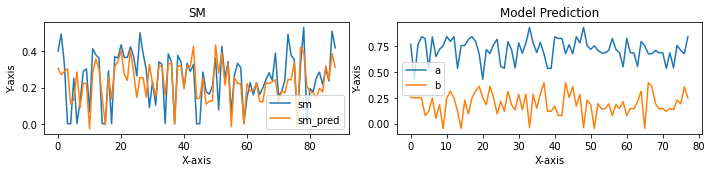

Epoch [116/5000] (LR: 7.8125e-06):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


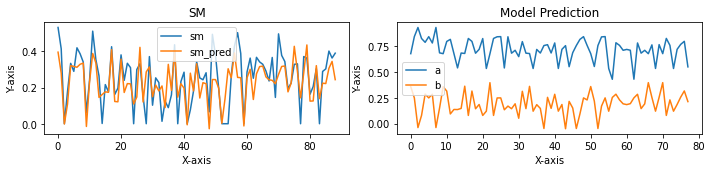

Epoch [117/5000] (LR: 7.8125e-06):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


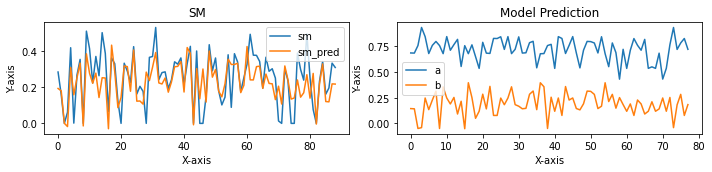

Epoch [118/5000] (LR: 7.8125e-06):
Train loss: 0.0170 || Train physical loss: 0.0170 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


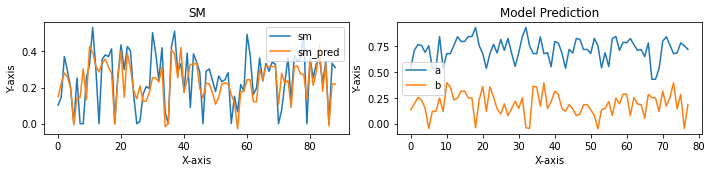

Epoch [119/5000] (LR: 7.8125e-06):
Train loss: 0.0151 || Train physical loss: 0.0151 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


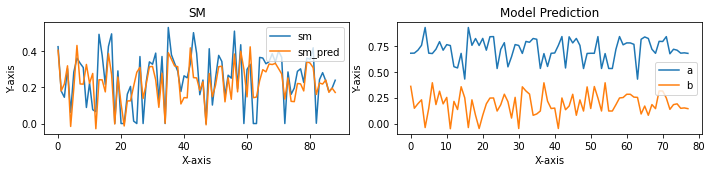

Epoch [120/5000] (LR: 7.8125e-06):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


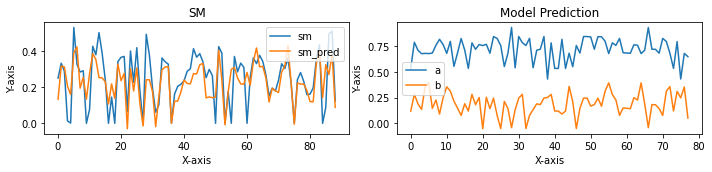

Epoch [121/5000] (LR: 7.8125e-06):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


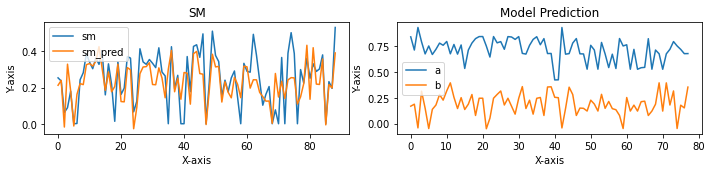

Epoch [122/5000] (LR: 7.8125e-06):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


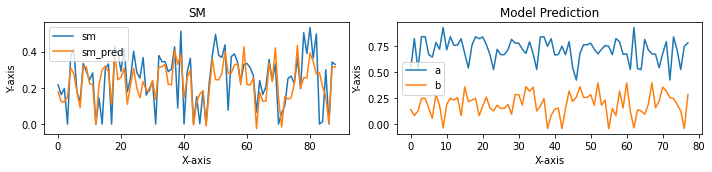

Epoch [123/5000] (LR: 7.8125e-06):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


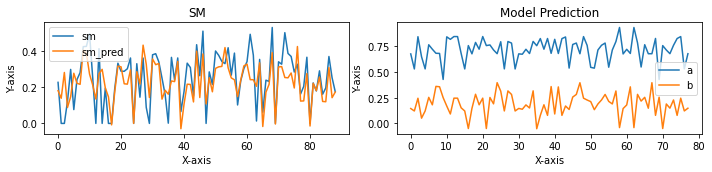

Epoch [124/5000] (LR: 3.90625e-06):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


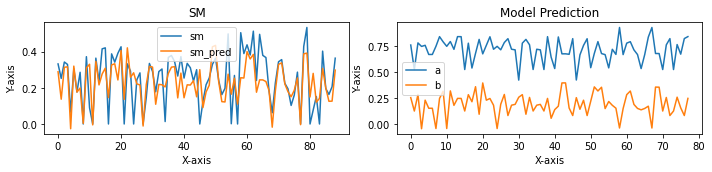

Epoch [125/5000] (LR: 3.90625e-06):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


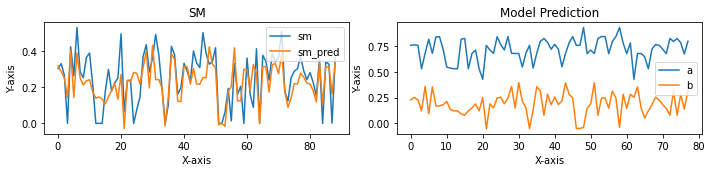

Epoch [126/5000] (LR: 3.90625e-06):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


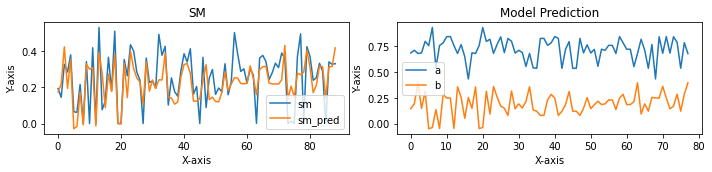

Epoch [127/5000] (LR: 3.90625e-06):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


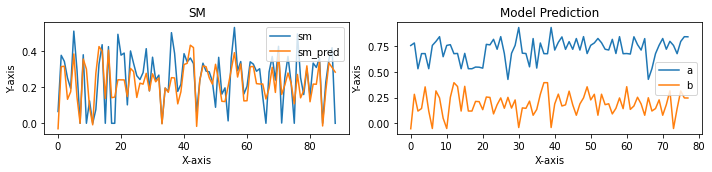

Epoch [128/5000] (LR: 3.90625e-06):
Train loss: 0.0157 || Train physical loss: 0.0157 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


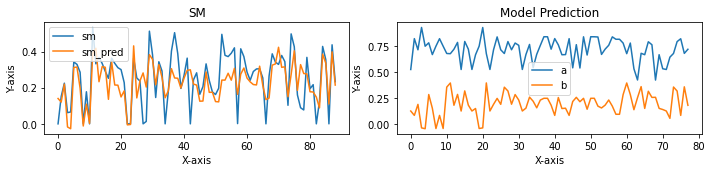

Epoch [129/5000] (LR: 3.90625e-06):
Train loss: 0.0155 || Train physical loss: 0.0155 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


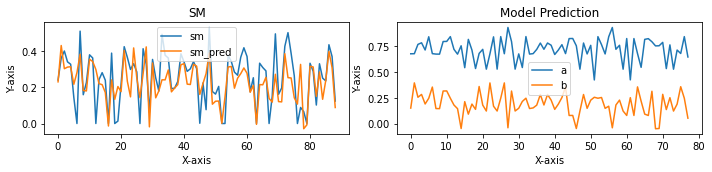

Epoch [130/5000] (LR: 3.90625e-06):
Train loss: 0.0159 || Train physical loss: 0.0159 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


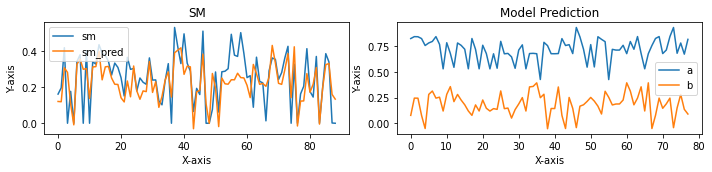

Epoch [131/5000] (LR: 3.90625e-06):
Train loss: 0.0154 || Train physical loss: 0.0154 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


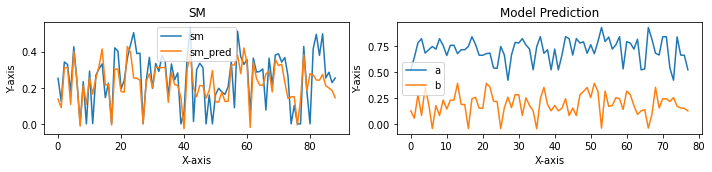

Epoch [132/5000] (LR: 3.90625e-06):
Train loss: 0.0158 || Train physical loss: 0.0158 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


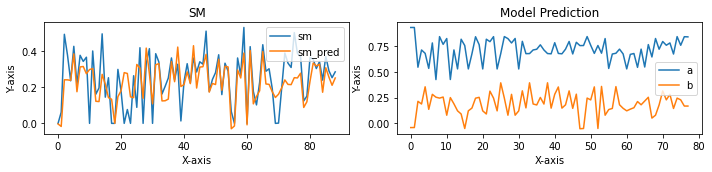

Epoch [133/5000] (LR: 3.90625e-06):
Train loss: 0.0156 || Train physical loss: 0.0156 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000


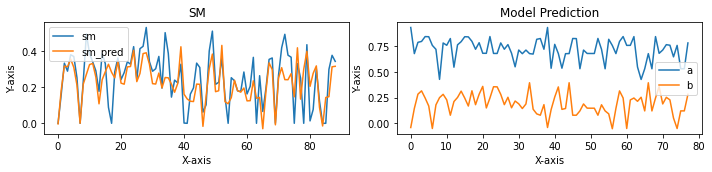

Epoch [134/5000] (LR: 3.90625e-06):
Train loss: 0.0153 || Train physical loss: 0.0153 || Train similarity loss: 0.0000
Valid loss: 0.0112 || Valid physical loss: 0.0112 || Valid similarity loss: 0.0000

Model is not improving, so we halt the training session.


In [8]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    param_path = os.path.join(config['model_pretrained_dir'],'first.ckpt' )
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    model.load_state_dict(torch.load(param_path))
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [11]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_sm_loss
    model.eval() 
    loss_record = []
    physical_loss_record = []
    sim_loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', 0)
            loss = physical_loss + sim_loss

        physical_loss_record.append(physical_loss.item())
        sim_loss_record.append(sim_loss.item())
        loss_record.append(loss.item())

    mean_test_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
    mean_test_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
    mean_test_loss = sum(loss_record)/len(loss_record)
        
    print(f'Test loss: {mean_test_loss:.4f} || Test physical loss: {mean_test_physical_loss:.4f} || Test similarity loss: {mean_test_sim_loss:.4f}')
    return physical_loss_record

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


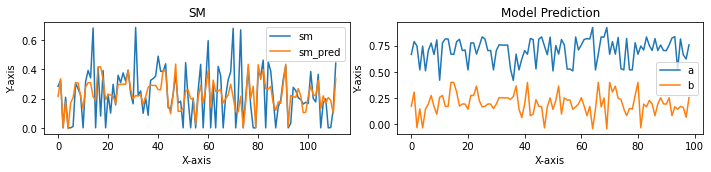

Test loss: 1.3579 || Test physical loss: 0.0196 || Test similarity loss: 1.3383


In [12]:
param_path = os.path.join(config['model_save_dir'],'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 